## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display as display
from IPython.core.pylabtools import figsize, getfigs
import math
import matplotlib.image as mpimg
import matplotlib.transforms as mtransforms
import numpy as np
import cv2
from tqdm import tqdm
   
def draw_image(img, title):
    """ Draw a single image with a title """
    f = plt.figure()
    plt.title(title)
    plt.imshow(img, cmap='gray')
    display(f)
    plt.close(f)
    
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def draw_grid(imgs, title='', img_shape = [100, 100], cols = 2, width = 5):
    rows = math.ceil(len(imgs)/cols)
    fig = plt.figure(figsize=(width, int(0.7*(img_shape[0]*rows)*width/(cols*img_shape[1]))))

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    for i in range(len(imgs)):
        grid[i].imshow(imgs[i], cmap='gray')
    fig.subplots_adjust(hspace=0)    
    plt.suptitle(title)    
    plt.show()
    
def toRGB(img):
    return cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)

In [44]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

def read_images(images):
    out_images = []
    for fname in images:
        img = cv2.imread(fname)
        out_images.append(img)
    return out_images

imgs = read_images(images)

class Camera:
    def __init__(self):
        self.cameraMatrix = None
        self.distCoeffs = None
        self.rvecs = None
        self.tvecs = None
        self.objpoints = []
        self.imgpoints = []
        
    def calibrate(self, imgs, draw = True):
        for img in tqdm(imgs):
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)

                if draw == True:
                    # Draw and display the corners
                    outimg = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                    draw_image(outimg, "Chessboard Corners")
                   
        retval, self.cameraMatrix, self.distCoeffs, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, gray.shape, None, None)
   
    def undistort(self, img, draw = True):
        out_img = cv2.undistort(img, self.cameraMatrix, self.distCoeffs, None, self.cameraMatrix)
        if draw == True:
            draw_image(out_img, "Undistorted")
        return out_img

camera = Camera()
camera.calibrate(imgs, False)

checkerboard_display_imgs = []
for img in tqdm(imgs):
    checkerboard_display_imgs.append(img)
    undistorted = camera.undistort(img, False)
    checkerboard_display_imgs.append(undistorted)


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


In [ ]:
draw_grid(checkerboard_display_imgs, "Distorted and undistorted", img.shape[:2], 2, 10)

## And so on and so forth...

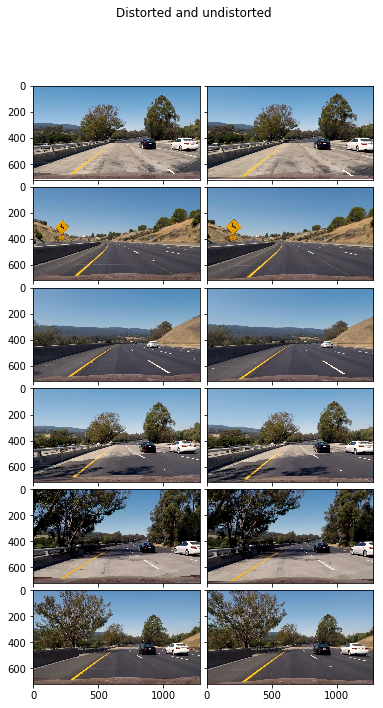

In [50]:
test_images = glob.glob('./test_images/test*.jpg')

test_images_display = []
for img in read_images(test_images):
    test_images_display.append(toRGB(img))
    undistorted = camera.undistort(img, False)
    test_images_display.append(toRGB(undistorted))
    
draw_grid(test_images_display, "Distorted and undistorted", test_images_display[0].shape[:2], 2, 10)

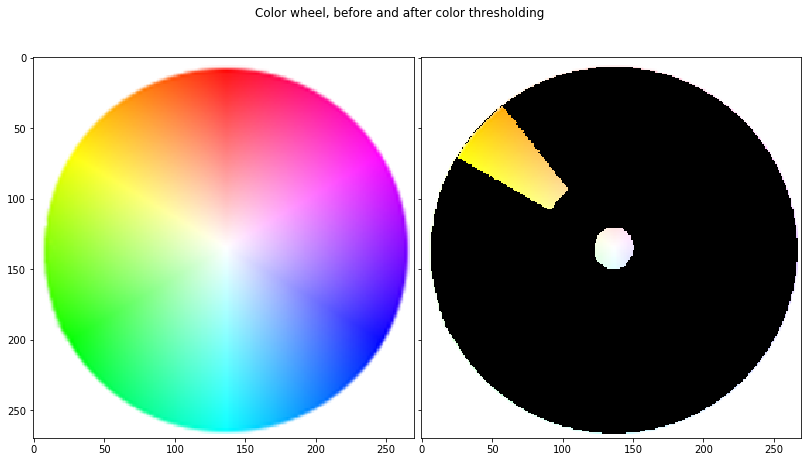

100%|██████████| 6/6 [00:00<00:00, 12.60it/s]


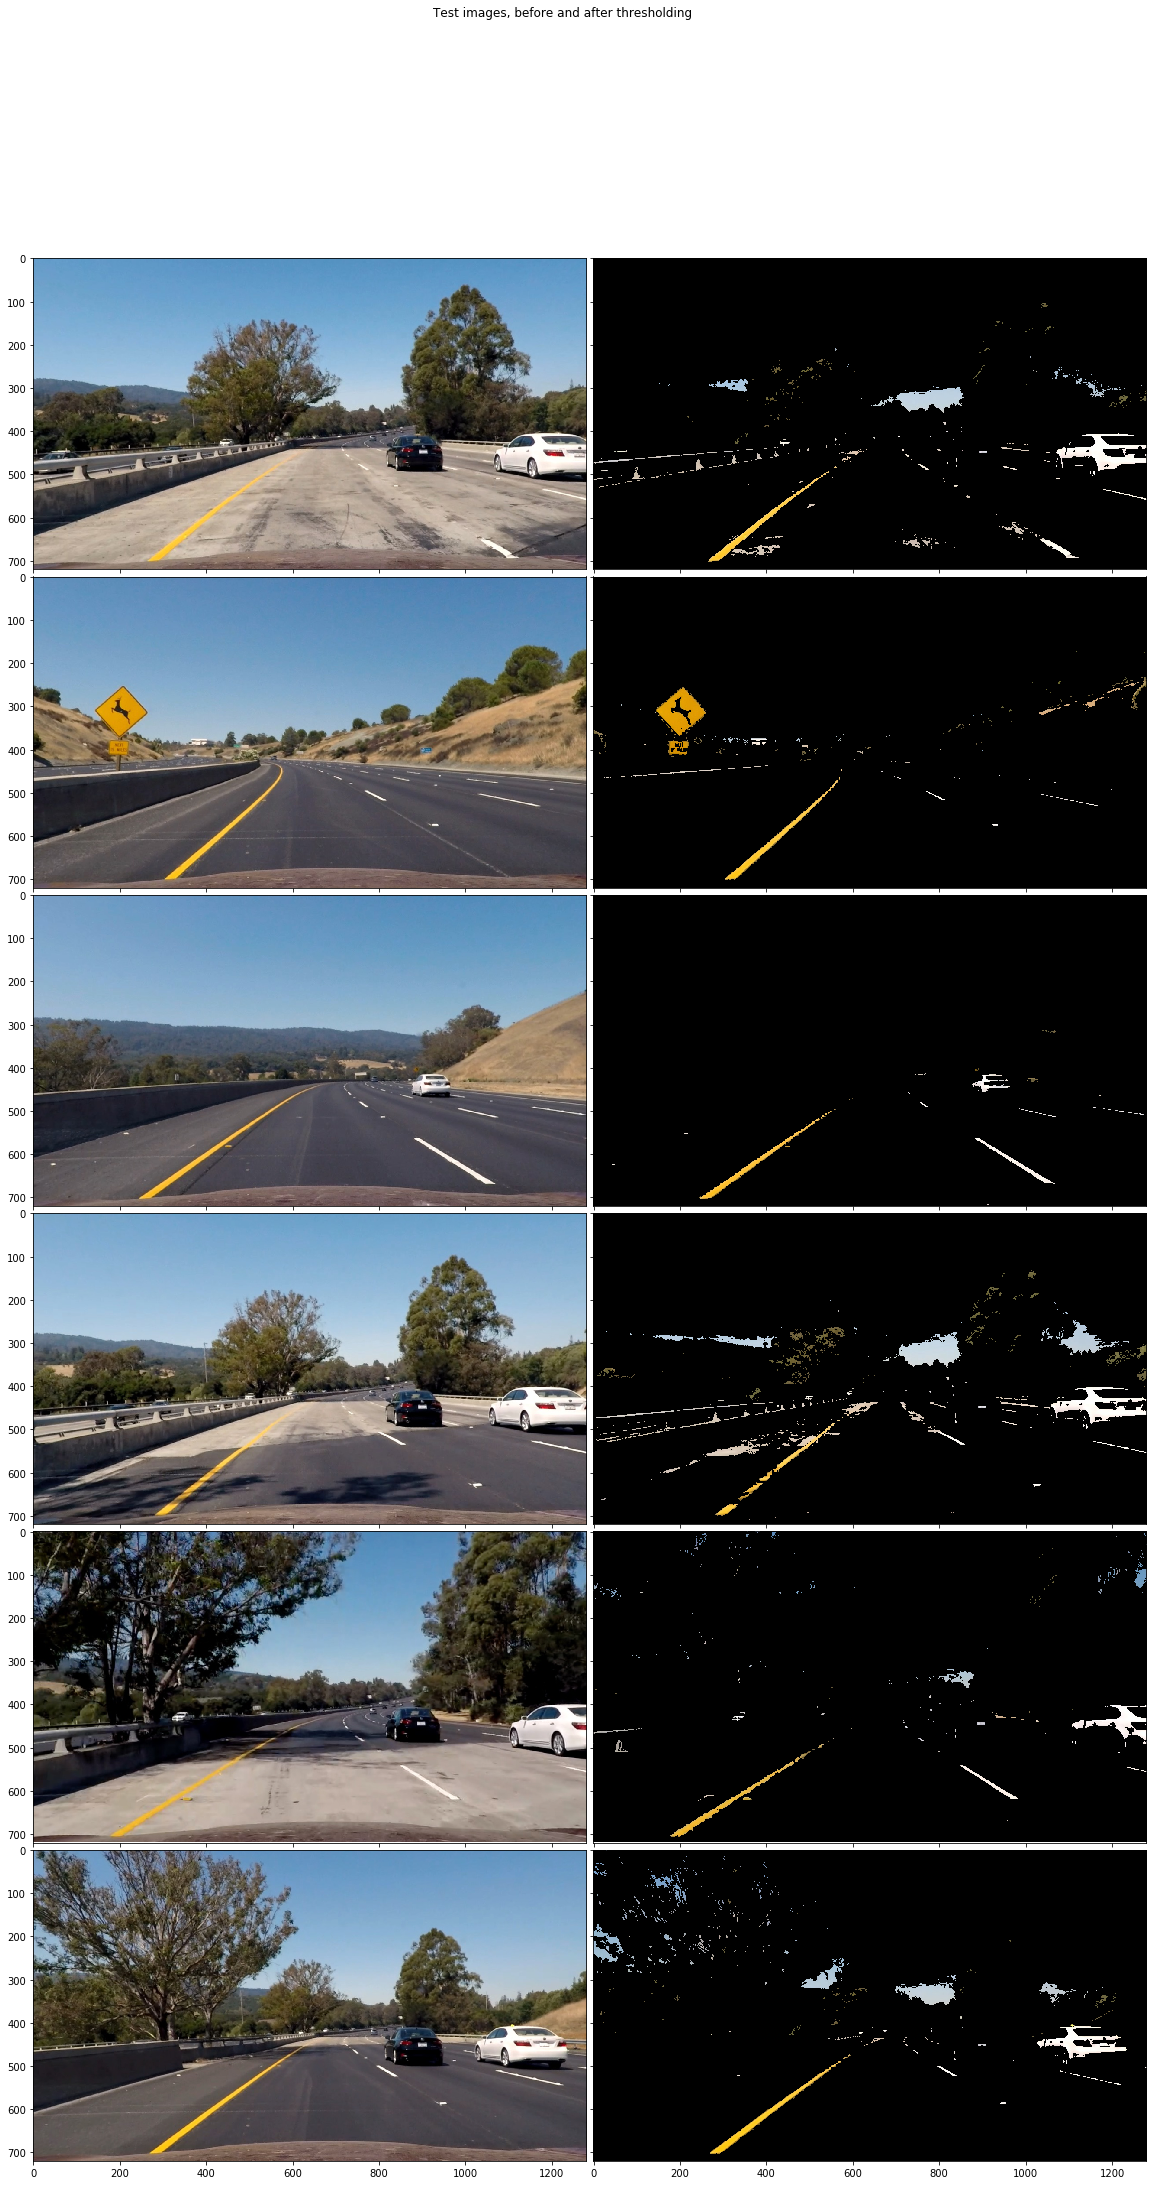

In [113]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
def color_crop_img(img):
    """Threshold the image in HSV color space to get yellow lines and
    HLS color space to get white and yellow lines, and return a mask
    of the regions containing those thresholded parts of the image."""
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    yellow_mask = cv2.inRange(hsv_image, np.array([90,100,100]), np.array([100, 255, 255]))
    hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l = clahe.apply(hls_img[:,:,1])
    l_mask = cv2.threshold(l, 225, 256, cv2.THRESH_BINARY)[1]
    both_mask = yellow_mask | l_mask
    return both_mask

def mask_image(img, mask):
    """Apply a mask to an image"""
    return cv2.bitwise_and(img, img, mask=mask)

def process(img):
    return mask_image(img, color_crop_img(img))
    

color_wheel = read_images(glob.glob('./examples/color-wheel.png'))
draw_grid([toRGB(color_wheel[0]), process(toRGB(color_wheel[0]))],
         "Color wheel, before and after color thresholding", color_wheel[0].shape[:2], 2, 20)

sample_images = []

for img in tqdm(read_images(test_images)):
    img_undistorted = camera.undistort(toRGB(img), False)
    sample_images.append(img_undistorted)
    sample_images.append(process(img_undistorted))
draw_grid(sample_images, "Test images, before and after thresholding", sample_images[0].shape[:2], 2, 30)
